# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [1]:
max_edges = 10000 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import export_graphviz
import pydot
from sklearn.ensemble import RandomForestRegressor
from __future__ import division
import sklearn
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.2.


## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [3]:
lines = []
total_line_count = 0
with open(edges_csv_file, 'rb') as f:
    f.readline()   # skip first line / header
    while True:
        line = f.readline()
        if not line:
            break
        if not (max_edges > 0 and len(lines) >= max_edges):
            lines.append(line)
        total_line_count += 1
G = nx.parse_edgelist(lines, delimiter=',', nodetype=int)

In [4]:
print "Using %d edges out of %d available (%.2f%% of data)" % (len(lines), total_line_count, len(lines)/total_line_count * 100)

Using 10000 edges out of 229338 available (4.36% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [5]:
centrality_measures = {}

#### Degree

In [6]:
centrality_measures["degree"] = nx.degree(G)

#### Eigenvector centrality

In [7]:
centrality_measures["eigenvector_centrality"] = nx.eigenvector_centrality_numpy(G)

####  Approximate betweenness centrality (current flow)

In [8]:
centrality_measures["betweenness_centrality"] = nx.approximate_current_flow_betweenness_centrality(G)

#### Closeness centrality

In [8]:
# Very slow!
centrality_measures["closeness_centrality"] = nx.closeness_centrality(G)

#### Betweenness centrality

In [9]:
# Very slow!
centrality_measures["betweenness_centrality"] = nx.betweenness_centrality(G)

### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [9]:
df = pd.read_csv(nodes_csv_file)

In [10]:
# Add columns to dataframe
def merge_columns(dataframe, data):
    df = dataframe.copy()
    for col in data:
        rows = []
        for item in data[col].items():
            rows.append({"id": item[0], col: item[1]})
        df = df.merge(pd.DataFrame(rows))
    return df

df = merge_columns(df, centrality_measures)

### Let's convert some fields to numeric

In [11]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory'
]

numeric_features = [
    'degree',
    'eigenvector_centrality',
    #'closeness_centrality',
    'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = df.replace("<<MISSING_DATA>>", np.NaN)
df[numeric_features] = df[numeric_features].apply(pd.to_numeric)
df[['price']] = df[['price']].apply(pd.to_numeric)

for feature in numeric_features:
    df[feature].fillna(df[feature].mean(), inplace = True)

### Remove nodes without price and outliers

In [12]:
df = df.drop(df[df["price"].isnull()].index)
#df = df.drop(df[df["price"] > 500].index)

### Inspect columns

In [13]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'eigenvector_centrality', u'degree',
       u'betweenness_centrality'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [14]:
df.describe(include='all')

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,...,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
count,1909.000000,1909,1909,1909,1894,1896,0.0,288,1680,1655,...,1909.000000,1909.000000,1909.000000,1909.000000,1909.000000,1909.000000,1909.000000,1.909000e+03,1909.000000,1909.000000
unique,NaN,1862,1909,1482,7,290,NaN,256,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Macroeconomia,https://www.amazon.com.br/dp/0198769865/,Platao (Autor),Capa comum,Companhia das Letras,NaN,17 de outubro de 2017,Livros,Livros,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,1,12,1525,99,NaN,3,1680,1655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1738.748559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,411.917069,13.756137,4.480701,15.964176,22.922106,2.303225,465.792815,8.063756e-03,9.107386,0.003999
std,2012.552396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,268.996034,34.143862,0.495171,2.880301,2.814048,1.211811,210.053265,2.092134e-02,18.504730,0.013215
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,1.000000,1.000000,2.600000,14.000000,0.200000,18.100000,8.902568e-08,1.000000,0.000000
25%,530.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,232.000000,3.000000,4.483894,14.000000,21.000000,1.400000,340.000000,8.496328e-06,1.000000,0.000000
50%,1236.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,352.000000,13.810619,4.483894,15.600000,22.900000,2.000000,468.748089,6.298340e-05,2.000000,0.000335
75%,1934.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,528.000000,13.810619,4.700000,17.200000,24.100000,2.900000,581.000000,2.377659e-03,8.000000,0.002814


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [15]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,...,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,...,68.0,1.000000,4.000000,14.0,21.0,0.6,181.0,0.014272,19,0.009452
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,...,352.0,3.000000,4.600000,14.6,21.0,1.9,363.0,0.060501,62,0.019712
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,160.0,13.810619,4.483894,14.4,20.8,0.8,200.0,0.041809,59,0.011665
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,320.0,2.000000,4.500000,13.7,21.5,1.6,381.0,0.013503,18,0.004864
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,848.0,4.000000,4.500000,13.8,21.8,4.0,939.0,0.084038,88,0.015381
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,418.0,1.000000,5.000000,13.8,21.5,2.2,581.0,0.051176,43,0.010736
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,...,160.0,13.810619,4.483894,13.7,21.5,0.8,159.0,0.010229,9,0.000904
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,...,160.0,2.000000,5.000000,13.8,21.6,1.0,159.0,0.005257,10,0.011436
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,...,480.0,13.810619,4.483894,13.6,20.3,2.3,522.0,0.022270,23,0.002556
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,112.0,13.810619,4.483894,14.0,20.3,1.3,159.0,0.008116,15,0.006233


## Random forest using degree as feature, price as target

### Preparing data

In [16]:
df_with_dummies = pd.get_dummies(df[["id"] + numeric_features + categorical_features + ['price']],columns=categorical_features,drop_first=True)

In [17]:
feature_list = list(df_with_dummies.drop(columns = ['price']))
features = np.array(df_with_dummies.drop(columns = ['price']))
target = np.array(df_with_dummies['price'])

### Average price as baseline

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

We have an average price around R\$43, so this means that a very easy prediction would be to always guess R$43 for the price of any book.

In [18]:
average_target = np.average(target)
print "Average price: R$", average_target

Average price: R$ 147.89485594552124


### Cross val score

In [19]:
def baseline_score_function (y_true, y_pred):
    errors_baseline = abs(average_target - y_true)
    return np.mean(errors_baseline)

rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)

scorer = make_scorer(baseline_score_function)

scores = cross_validate(estimator=rf, X=features, y=target, cv=10,
                        scoring = {'abs': 'neg_mean_absolute_error', 'baseline': scorer},
                        return_train_score=False, return_estimator = True)

#print "Abs: ", scores['test_abs']
print "RF abs mean: ", np.mean(np.abs(scores['test_abs']))
print "RF abs std: ", np.std(scores['test_abs'])

#print "Baseline: ", scores['test_baseline']
print "Baseline mean: ", np.mean(scores['test_baseline'])
print "Baseline std: ", np.std(scores['test_baseline'])

# Use best estimator to do some visual reports
rf = scores['estimator'][0]

RF abs mean:  66.28336443813723
RF abs std:  60.19171590460038
Baseline mean:  145.21898725378952
Baseline std:  82.89667325215902


In [20]:
predictions = rf.predict(features)
test_target = target
test_features = features

####  List of most important features

In [21]:
importance = zip(feature_list, rf.feature_importances_)
importance.sort(key=lambda x:-x[1])
pd.DataFrame(importance).head(200)

,0,1
0,eigenvector_centrality,0.296665
1,pages,0.193773
2,coverType_Capa dura,0.094669
3,width,0.055928
4,publisher_McGraw-Hill Science/Engineering/Math,0.045718
5,category2_Inglês e Outras Línguas,0.034433
6,ranking,0.032172
7,publisher_Cengage Learning,0.029606
8,depth,0.027002
9,betweenness_centrality,0.026326


####  Preço previsto vs. Preço real

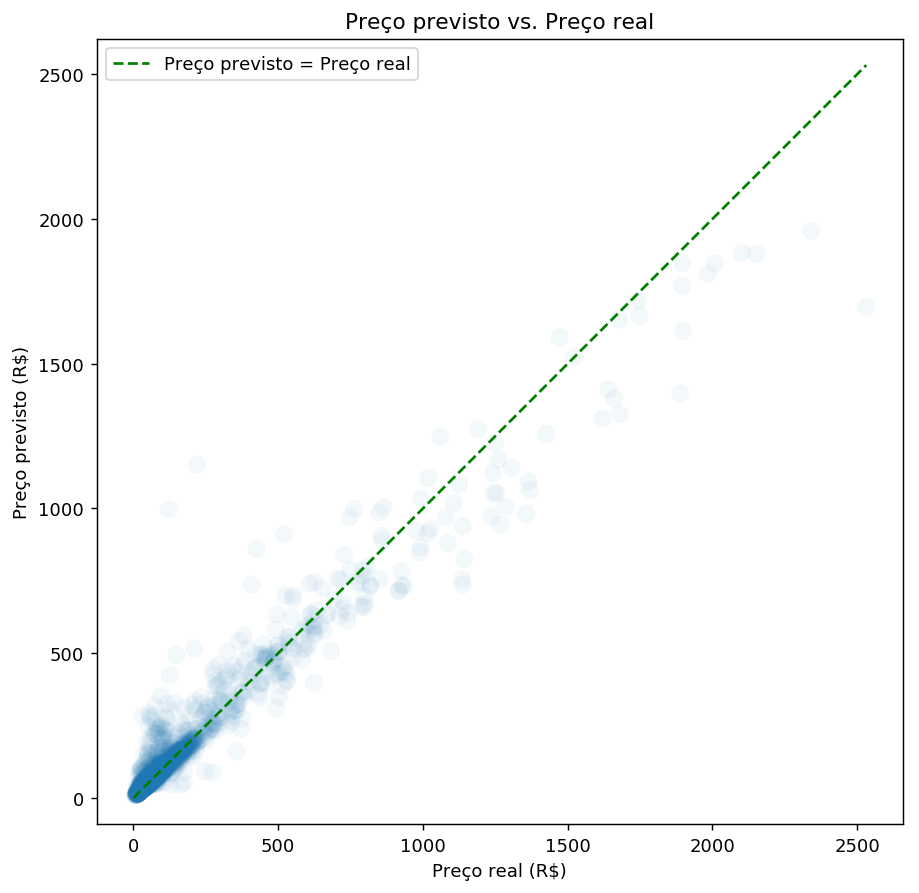

In [22]:
plt.figure(figsize=(8,8), dpi=130)
plt.scatter(target, predictions, 100, alpha=0.05, edgecolors="none")
baseline = [0, np.max(target)]
plt.plot(baseline, baseline, "--", color="green", label = u"Preço previsto = Preço real")
ax = plt.gca()
ax.set_ylabel(u"Preço previsto (R$)")
ax.set_xlabel(u"Preço real (R$)")
ax.legend()
plt.title(u"Preço previsto vs. Preço real")
plt.axes().set_aspect('equal', 'datalim')
#plt.xlim(0, 150)
#plt.ylim(0, 150)
plt.show()

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [23]:
# Calculate the absolute errors
errors = abs(predictions - test_target)
errors_baseline = abs(average_target - test_target)
# Print out the mean absolute error (mae)
print('Mean absolute prediction error: R$', round(np.mean(errors), 2))
print('Mean absolute error using average: R$',
      round(np.mean(errors_baseline), 2))

('Mean absolute prediction error: R$', 26.07)
('Mean absolute error using average: R$', 145.25)


### Worst predictions

Below we can inspect the rows with the biggest prediction error.

In [24]:
pd.set_option('display.max_columns', None)
data = {
    "all_features": test_features.tolist(),
    "id": test_features[:, 0],
    "target": test_target,
    "prediction": predictions,
    "error": errors,
    "errors_baseline": errors_baseline
}
predicted_df = pd.DataFrame(data = data)
joined_predicted_df = predicted_df
joined_predicted_df = predicted_df.set_index("id").join(df.set_index("id"))
joined_predicted_df.sort_values('error', ascending = False).head(20)

,all_features,error,errors_baseline,prediction,target,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
181.0,"[181.0, 54.0, 0.00139151138325, 0.074534869694...",931.6142,71.465144,1150.9742,219.36,Princípios de Química,https://www.amazon.com.br/dp/8540700387/,Peter Atkins (Autor),Capa dura,Bookman,NaN,NaN,Livros,Livros,Medicina,Ciência Básica,Bioquímica,NaN,NaN,NaN,NaN,NaN,NaN,8540700387,978-8540700383,Português,1,219.36,2409.000000,1048.000000,39.000000,4.700000,22.000000,28.400000,4.000000,468.748089,0.001392,54,0.074535
98.0,"[98.0, 24.0, 0.00500851886131, 0.0645170994617...",874.5156,25.394856,997.0156,122.50,Física Conceitual,https://www.amazon.com.br/dp/8582603401/,Paul G. Hewitt (Autor),Capa dura,Bookman,NaN,NaN,Livros,Livros,Ciências,Física,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8582603401,978-8582603406,Português,1,122.50,9036.000000,816.000000,14.000000,4.800000,21.000000,28.200000,3.200000,468.748089,0.005009,24,0.064517
1685.0,"[1685.0, 13.0, 0.0249982911487, 0.001244811470...",835.0864,2383.175144,1695.9836,2531.07,Complex Analysis Complex Analysis Complex Anal...,https://www.amazon.com.br/dp/0070006571/,"Lars V. Ahlfors (Autor),",Capa dura,McGraw-Hill Science/Engineering/Math,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0070006571,978-0070006577,Inglês,1,2531.07,59923.541284,345.000000,13.810619,4.483894,16.000000,23.100000,2.500000,468.748089,0.024998,13,0.001245
1712.0,"[1712.0, 12.0, 0.0220459396529, 0.001356787289...",492.0588,1740.865144,1396.7012,1888.76,Vector Calculus,https://www.amazon.com.br/dp/1429215089/,"Jerrold E. Marsden (Autor),",Capa dura,W.H. Freeman & Company,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Análise Vetorial,NaN,NaN,NaN,NaN,1429215089,978-1429215084,Inglês,1,1888.76,311760.000000,545.000000,13.810619,4.483894,21.000000,26.000000,3.200000,468.748089,0.022046,12,0.001357
43.0,"[43.0, 24.0, 0.00353727004178, 0.0650990342266...",433.3876,278.255144,859.5376,426.15,Lições de Física de Feynman - 4 Volumes,https://www.amazon.com.br/dp/8577802590/,Richard P. Feynman (Autor),Capa dura,Bookman,NaN,NaN,Livros,Livros,Ciências,Física,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8577802590,978-8577802593,Português,1,426.15,29423.000000,1798.000000,12.000000,4.800000,22.600000,29.800000,8.800000,468.748089,0.003537,24,0.065099
1830.0,"[1830.0, 32.0, 0.0421584506269, 0.005828376637...",400.1228,988.385144,736.1572,1136.28,Geometric Algebra,https://www.amazon.com.br/dp/0471608394/,E. Artin (Autor),Capa comum,Wiley-Blackwell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0471608394,978-0471608394,Inglês,1,1136.28,59923.541284,224.000000,13.810619,4.483894,14.700000,22.900000,1.200000,308.000000,0.042158,32,0.005828
95.0,"[95.0, 155.0, 0.166782686263, 0.0122085056601,...",389.6904,372.315144,909.9004,520.21,"Modern Classical Physics – Optics, Fluids, Pla...",https://www.amazon.com.br/dp/0691159025/,"Kip Thorne (Autor),",Capa dura,Princeton University Press,NaN,25 de agosto de 2017,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,NaN,NaN,NaN,NaN,NaN,NaN,0691159025,978-0691159027,Inglês,1,520.21,13437.000000,1552.000000,1.000000,5.000000,20.300000,26.700000,6.400000,468.748089,0.166783,155,0.012209
1779.0,"[1779.0, 13.0, 0.0296845571371, 0.001480885052...",382.4566,2193.305144,1958.7434,2341.20,Modern Physics for Scientists and Engineers,https://www.amazon.com.br/dp/1133103723/,"Stephen T. Thornton (Autor),",Capa dura,Cengage Learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1133103723,978-1133103721,Inglês,1,2341.20,59923.541284,688.000000,13.810619,4.483894,20.300000,25.400000,3.200000,468.748089,0.029685,13,0.001481
1789.0,"

### Best predictions

In [25]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,errors_baseline,prediction,target,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
268.0,"[268.0, 18.0, 0.000241614131885, 0.01750324761...",0.0198,103.994856,43.9198,43.90,Almanaque Das Curiosidades Matemáticas,https://www.amazon.com.br/dp/8537801623/,Ian Stewart (Autor),Capa comum,Zahar,NaN,NaN,Livros,Livros,Ciências,Matemática,História,NaN,NaN,NaN,NaN,NaN,NaN,8537801623,978-8537801628,Português,1,43.90,38157.0,316.0,4.000000,4.700000,15.4,20.8,2.0,522.000000,2.416141e-04,18,1.750325e-02
396.0,"[396.0, 3.0, 6.31313076235e-05, 0.000303021857...",0.0236,115.994856,31.9236,31.90,O Médico Quântico,https://www.amazon.com.br/dp/8531609410/,Amit Goswami (Autor),Capa comum,Cultrix,NaN,NaN,Livros,Livros,Saúde e Família,Medicina Alternativa,Holística,NaN,NaN,NaN,NaN,NaN,NaN,8531609410,978-8531609411,Português,1,31.90,18206.0,288.0,2.000000,5.000000,15.8,22.6,1.4,422.000000,6.313131e-05,3,3.030219e-04
563.0,"[563.0, 5.0, 0.000210105187053, 0.003753725407...",0.0282,77.994856,69.9282,69.90,"Einstein. Sua Vida, Seu Universo",https://www.amazon.com.br/dp/8535911286/,"Walter Isaacson (Autor),",Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,Biografias e Histórias Reais,Históricas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8535911286,978-8535911282,Português,1,69.90,15001.0,696.0,12.000000,4.300000,16.6,23.4,3.8,468.748089,2.101052e-04,5,3.753725e-03
607.0,"[607.0, 1.0, 0.000281983526454, 0.0, 6295.0, 1...",0.0382,121.294856,26.5618,26.60,Lições dos Mestres,https://www.amazon.com.br/dp/8501113115/,"George Steiner (Autor),",Capa comum,Record,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8501113115,978-8501113115,Português,1,26.60,6295.0,196.0,1.000000,5.000000,15.0,22.6,1.4,281.000000,2.819835e-04,1,0.000000e+00
7798.0,"[7798.0, 1.0, 5.77391501898e-06, 0.0, 51190.0,...",0.0386,117.214856,30.7186,30.68,Antes e Depois de Sócrates,https://www.amazon.com.br/dp/8533614497/,Francis McDonald Cornford (Autor),Capa comum,WMF Martins Fontes,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8533614497,978-8533614499,Português,1,30.68,51190.0,100.0,13.810619,4.483894,13.6,19.8,1.0,200.000000,5.773915e-06,1,0.000000e+00
1476.0,"[1476.0, 2.0, 0.000371902788702, 7.6586086739e...",0.0396,109.004856,38.8504,38.89,Nothing,https://www.amazon.com.br/dp/0199225869/,Frank Close (Autor),Capa comum,"Oxford University Press, USA",NaN,1 de julho de 2009,Livros,Livros,Inglês e Outras Línguas,"Política, Filosofia e Ciências Sociais",Filosofia,Movimentos,Existencialismo,NaN,NaN,NaN,NaN,0199225869,978-0199225866,Inglês,1,38.89,64715.0,157.0,13.810619,4.483894,11.2,17.3,1.3,159.000000,3.719028e-04,2,7.658609e-05
1467.0,"[1467.0, 5.0, 0.00715839925891, 0.000959197628...",0.0444,103.714856,44.1356,44.18,Perception: A Very Short Introduction,https://www.amazon.com.br/dp/0198791003/,Brian Rogers (Autor),Capa comum,OUP Oxford,NaN,26 de outubro de 2017,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Ciências Comportamentais,Psicologia Cognitiva,NaN,NaN,NaN,NaN,NaN,0198791003,978-0198791003,Inglês,1,44.18,249487.0,184.0,13.810619,4.483894,11.2,17.3,1.3,141.000000,7.158399e-03,5,9.591976e-04
571.0,"[571.0, 2.0, 5.30726392385e-05, 0.000213222093...",0.0514,125.664856,22.1786,22.23,Minhas Invenções. A Autobiografia de Nikola Tesla,https://www.amazon.com.br/dp/8539303590/,Vários Autores (Autor),Capa comum,UNESP,NaN,NaN,Livros,Livros,Biografias e Histórias Reais,Profissionais e Universitários,Ciências Sociais e Psicologia,NaN,NaN,NaN,NaN,NaN,NaN,8539303590,978-8539303595,Português,1,22.23,13940.0,120.0,8.000000,4.600000,11.8,20.6,0.8,14

In [26]:
predicted_df.describe()

,error,errors_baseline,id,prediction,target
count,1909.00000,1909.000000,1909.000000,1909.000000,1909.000000
mean,26.06970,145.247433,1738.748559,151.470645,147.894856
std,61.87162,221.577470,2012.552396,243.255382,264.961222
min,0.01980,0.065144,1.000000,9.249400,5.900000
25%,2.01060,72.904856,530.000000,38.138400,35.900000
50%,5.75140,103.204856,1236.000000,61.403600,56.900000
75%,19.63260,121.994856,1934.000000,147.735600,126.850000
max,931.61420,2383.175144,9991.000000,1958.743400,2531.070000


### Visualize decision tree

In [27]:
# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',
                feature_names = feature_list, rounded = True)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

<img src="files/image.png">